# WWQR Mechanism Kinematic Analysis using SymPy

This notebook performs **position, velocity, and acceleration analysis** of a WWQR (Whitworth Quick Return) mechanism using:
- **SymPy** for symbolic solving (exact, but slower than numerical methods)
- **NumPy** for array operations
- **Matplotlib** for visualization

The mechanism consists of two kinematic loops that are solved sequentially to find the motion of slider position **x**.

---

## Import Required Libraries

In [55]:
import numpy as np
import sympy as sp
from IPython.display import Image
import matplotlib.pyplot as plt
from scipy import optimize as op

# Setting up the problem statement and Loop Closure(LC) Equations

### Mechanism Diagram
Visual representation of the complete WWQR mechanism showing all links and joints.

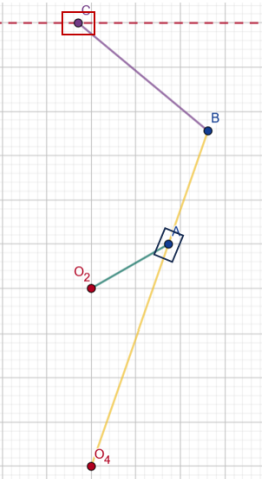

In [56]:
Image('WWQR.png')

---

## Loop Closure Equations

The mechanism is analyzed using **two kinematic loops** that are solved sequentially.

### Loop 1: Four-Bar Linkage (O2-A-O4 triangle)

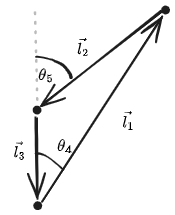

In [ ]:
Image('LC1.png')

Loop Closure Equation for Loop - 1
$$
\left\{
\begin{aligned}
    l_1 \cos\theta_4 - l_2 \cos\theta_2 - l_3 &= 0 = f_1(l_1, \theta_4) \\
    l_1 \sin\theta_4 - l_2 \sin\theta_2 &= 0 = f_2(l_1, \theta_4)
\end{aligned}
\right\}
\quad \Rightarrow \text{solve for } l_1, \theta_4
$$

### Loop 2: Slider Mechanism (O4-B-C-slider triangle)

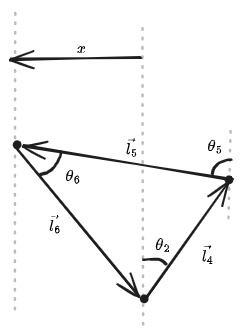

In [ ]:
Image('LC2.png')

$$
\left\{
\begin{aligned}
    l_3 \cos\theta_4 + l_5 \cos\theta_5 - l_6 \cos\theta_6 &= 0 = g_1(x, \theta_5) \\
    l_4 \sin\theta_4 - l_5 \sin\theta_5 - x &= 0 = g_2(x, \theta_5)
\end{aligned}
\right\}

\quad \Rightarrow \text{solve for } x, \theta_5
$$

Positions are obtained by solving the $f$ equations for $\theta_4$, and substituting it in the $g$ equations to find $x$, and $\theta_5$\
Velocity and acceleration is just derived from $\dot{f_i}$ and $\dot{g_i}$, which becomes linear system of equations.

---

## Define Mechanism Dimensions

Set up the link lengths for the WWQR mechanism:
- **O2A** = 1 m (crank length)
- **O2O4** = 2 m (fixed distance between ground pivots)
- **O4B** = 4 m (rocker length)
- **BC** = 1.9 m (connecting rod to slider)

In [60]:
O2A = 1
O2O4 = 2
O4B = 4
BC = 1.9

OMEGA = 1  # rad/s
ALPHA = 0  # rad/s²

---

# Main Solver Function

## Pre-computation Strategy (for Speed)

How is this different from earlier versions without optimization:
1. **Define symbolic expressions ONCE** (outside the function)
2. **Pre-compute derivatives** (`dotF`) outside the function
3. **Only symbolic solving happens inside** the function

This approach avoids redundant symbolic differentiation on each function call, significantly improving performance.

## Function: `full_solve_sympy(theta2val)`

Solves the complete kinematic analysis for a given crank angle θ₂ using **pure SymPy symbolic solving**:

**Input:** 
- `theta2val` (float): Crank angle in radians

**Output:** 
- List of 3 elements: `[solve1deg, solve2deg, solve3deg]`
  - `solve1deg` = `{l1: val, theta4: val, x: val, theta5: val}` (dict)
  - `solve2deg` = `[{dotl1: val, dottheta4: val, dotx: val, dottheta5: val}]` (list of dict)
  - `solve3deg` = `{ddotl1: val, ddottheta4: val, ddotx: val, ddottheta5: val}` (dict)

**Solution Strategy:**
1. **Position Analysis**: Solve nonlinear loop equations using `sp.solve`
2. **Velocity Analysis**: Solve linear system from differentiated equations using `sp.solve`
3. **Acceleration Analysis**: Solve linear system from second derivatives using `sp.solve`

**Note:** This method is slower than numerical solvers (~1 second per angle) but provides exact symbolic solutions.

In [ ]:
t = sp.symbols("t")
l1 = sp.Function("l_1")(t)  # = O4A
theta4 = sp.Function("theta_4")(t)
x = sp.Function("x")(t)
theta5 = sp.Function("theta_5")(t)
theta2 = sp.Function("theta_2")(t)

f1 = l1*sp.cos(theta4)-O2A*sp.cos(theta2)-O2O4
f2 = l1*sp.sin(theta4)-O2A*sp.sin(theta2)
g1 = O4B*sp.cos(theta4)+BC*sp.cos(theta5)-4
g2 = O4B*sp.sin(theta4)-BC*sp.sin(theta5)-x

F = [f1, f2, g1, g2]

# Define derivative symbols
dotl1 = sp.Function("l_1d")(t)
dotx = sp.Function("x_d")(t)
dottheta4 = sp.Function("theta_4d")(t)
dottheta5 = sp.Function("theta_5d")(t)
ddotl1 = sp.Function("l_1dd")(t)
ddotx = sp.Function("x_dd")(t)
ddottheta4 = sp.Function("theta_4dd")(t)
ddottheta5 = sp.Function("theta_5dd")(t)

# Compute derivatives once
dotF = [sp.diff(f, t) for f in F]

def full_solve_sympy(theta2val: float) -> list:
    '''
    Returns [position_dict, velocity_list, acceleration_dict]
    where position_dict = {l1: val, theta4: val, theta5: val, x: val}
    velocity_list = [{dotl1: val, dottheta4: val, dotx: val, dottheta5: val}]
    acceleration_dict = {ddotl1: val, ddottheta4: val, ddotx: val, ddottheta5: val}
    '''
    # Solve position equations
    f1_val = f1.subs(theta2, theta2val).evalf()
    f2_val = f2.subs(theta2, theta2val).evalf()
    
    _list = sp.solve([f1_val, f2_val], [l1, theta4])
    for i in _list:
        if i[0] < 0:
            continue
        theta4i = float(i[1])
        l1i = float(i[0])
        
        # Solve for x and theta5
        g2theta4eval = g2.subs(theta4, theta4i).evalf()
        g1theta4eval = g1.subs(theta4, theta4i).evalf()
        listvar2 = sp.solve([g1theta4eval, g2theta4eval], [x, theta5])
        
        for j in listvar2:
            if j[1] <= np.pi/2:
                xj = float(j[0])
                theta5j = float(j[1])
                break
        break
    
    solve1deg = {l1: l1i, theta4: theta4i, theta5: theta5j, x: xj}
    
    # Velocity analysis
    subs2degdict = {
        sp.Derivative(theta4, t): dottheta4,
        sp.Derivative(l1, t): dotl1,
        sp.Derivative(x, t): dotx,
        sp.Derivative(theta5, t): dottheta5,
        theta4: theta4i, l1: l1i, x: xj, theta5: theta5j,
        sp.Derivative(theta2, t): OMEGA,
        theta2: theta2val
    }
    
    dotF_val = [dotf.subs(subs2degdict).evalf() for dotf in dotF]
    
    solve2deg = sp.solve(dotF_val, [dotl1, dottheta4, dotx, dottheta5], list=True)
    
    # Acceleration analysis
    subs3degdict = {
        sp.Derivative(theta4, t): dottheta4,
        sp.Derivative(l1, t): dotl1,
        sp.Derivative(x, t): dotx,
        sp.Derivative(theta5, t): dottheta5,
        sp.Derivative(theta4, t, t): ddottheta4,
        sp.Derivative(l1, t, t): ddotl1,
        sp.Derivative(x, t, t): ddotx,
        sp.Derivative(theta5, t, t): ddottheta5,
        theta4: theta4i, l1: l1i, x: xj, theta5: theta5j,
        sp.Derivative(theta2, t, t): ALPHA,
        sp.Derivative(theta2, t): OMEGA,
        theta2: theta2val
    }
    
    ddotF_val = [sp.diff(dotf, t).subs(subs3degdict).evalf() for dotf in dotF]
    
    solve3deg = sp.solve(ddotF_val, [ddotl1, ddottheta4, ddotx, ddottheta5])
    for i in solve3deg:
        solve3deg[i] = solve3deg[i].subs(solve2deg)
    
    return [solve1deg, solve2deg, solve3deg]

---

## Test the Solver

### Performance Benchmark
Measure computation time for a single angle.

**Expected:** ~0.5-1.5 seconds (much slower than SciPy numerical methods which take ~0.01-0.05 seconds)

In [ ]:
import time
starttime = time.time()
final_x = full_solve_sympy(40*np.pi/180)
endtime = time.time()
print("Time to calculate: ", endtime-starttime, "s")
# print("Final x: ", final_x)

Time to calculate:  1.1502156257629395 s


### View Results
Display the complete solution structure to verify correctness.

In [49]:
print(final_x)

[{l_1(t): 2.8397495967912247, theta_4(t): 0.22833250450930404, theta_5(t): 1.51612739977846, x(t): -0.9917469580096873}, {l_1d(t): -0.452707246028211, theta_4d(t): 0.313992195816950, theta_5d(t): -0.149851813864011, x_d(t): 1.23892785530805}, {l_1dd(t): -0.611685177737912, theta_4dd(t): -0.0593059901243496, theta_5dd(t): -0.175400760355070, x_dd(t): -0.259520862013116}]


---

# Complete Kinematic Analysis Over Full Rotation

## Generate Position, Velocity, and Acceleration Plots

Compute slider kinematics for one complete crank rotation (0° to 360°).

Another thing to observe is that it almost takes 1 second to calculate $x$ for one value of $\theta_2$. For higher resolution, it will take up more time. Trying with a resolution that's fine enough, as well as accounts for time is crucial.

### Compute Slider Kinematics for Full Cycle

Loop through all crank angles and extract slider data:
- **Position** (x): `result[0][x]` - horizontal position of slider
- **Velocity** (ẋ): `result[1][0][dotx]` - slider speed
- **Acceleration** (ẍ): `result[2][ddotx]` - slider acceleration

**Resolution Trade-off:** With SymPy symbolic solving taking ~1 second per angle:
- **20° increments** (18 points) → ~18 seconds total
- **10° increments** (36 points) → ~36 seconds total
- **5° increments** (72 points) → ~72 seconds total

Choose resolution based on your time budget. Lower resolution gives faster computation but less smooth curves.

In [ ]:
theta2degRESOL = 20
theta2list = np.arange(0, 361, theta2degRESOL) * np.pi / 180

xlist = []
for theta2 in theta2list:
    result = full_solve_sympy(theta2)
    
    x_pos = float(result[0][x])                    # position
    x_vel = float(result[1][0][dotx])             # velocity
    x_acc = float(result[2][ddotx])               # acceleration
    
    xlist.append([x_pos, x_vel, x_acc])
    
xlist = np.array(xlist)

### Plot Kinematic Results

Create three-subplot figure showing:
1. **Position** (m) vs. θ₂ - slider displacement
2. **Velocity** (m/s) vs. θ₂ - slider speed
3. **Acceleration** (m/s²) vs. θ₂ - slider acceleration

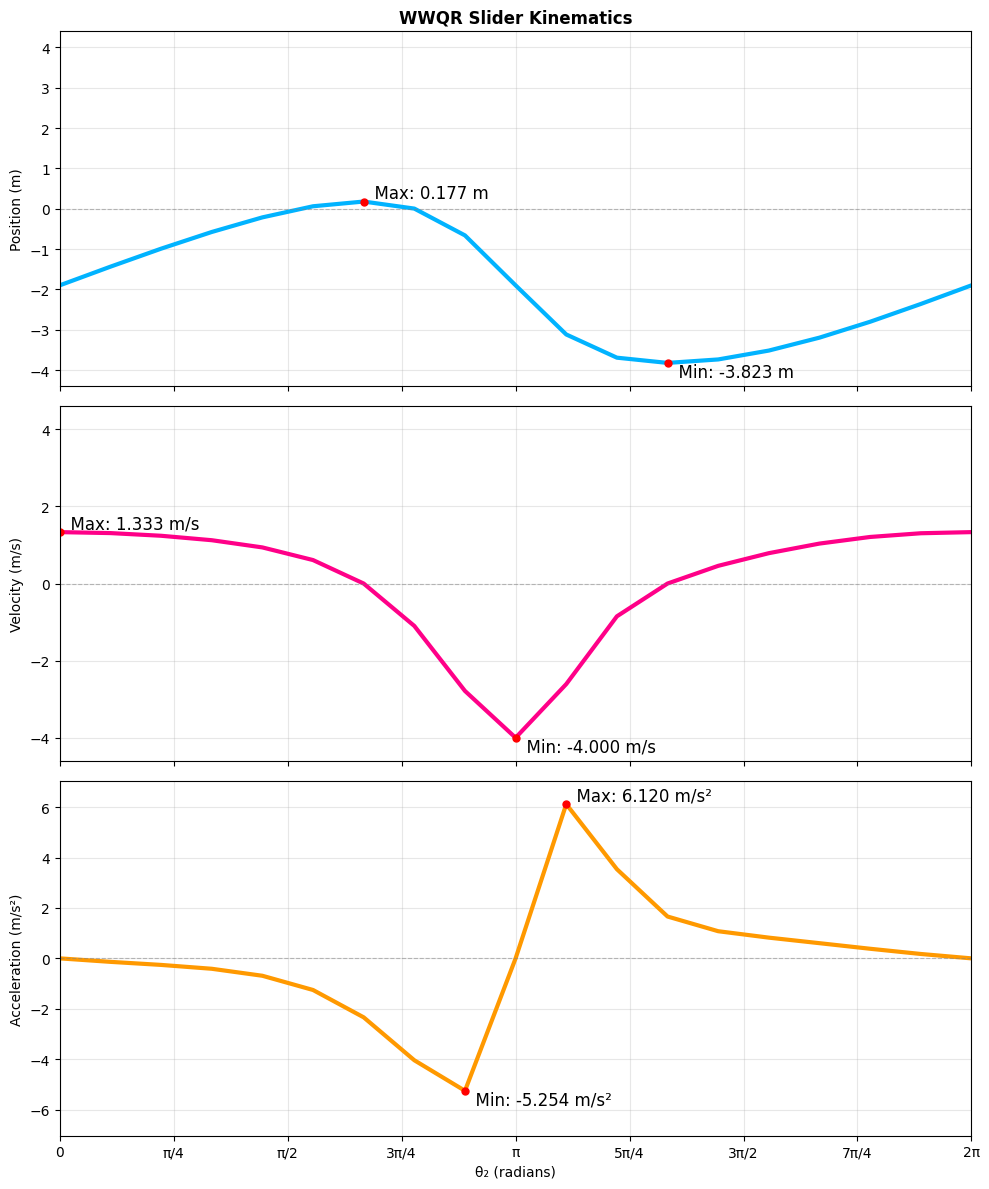

In [54]:
theta2_rad = theta2list
theta2_deg = theta2list * 180 / np.pi

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
colors = ["#01B3FF", "#FF0088", "#FF9900"]

# Position plot
axes[0].plot(theta2_rad, xlist[:, 0], color=colors[0], linewidth=3)
axes[0].set_ylabel('Position (m)', fontsize=10)
axes[0].axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
axes[0].set_title('WWQR Slider Kinematics', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
maxabs_pos = np.nanmax(np.abs(xlist[:, 0]))
axes[0].set_ylim(-maxabs_pos * 1.15, maxabs_pos * 1.15)

# Annotate max and min for position
if not np.all(np.isnan(xlist[:, 0])):
    idx_max = np.nanargmax(xlist[:, 0])
    idx_min = np.nanargmin(xlist[:, 0])
    axes[0].plot(theta2_rad[idx_max], xlist[idx_max, 0], 'ro', markersize=5)
    axes[0].plot(theta2_rad[idx_min], xlist[idx_min, 0], 'ro', markersize=5)
    axes[0].text(theta2_rad[idx_max], xlist[idx_max, 0],
                 f'  Max: {xlist[idx_max, 0]:.3f} m', fontsize=12, va='bottom')
    axes[0].text(theta2_rad[idx_min], xlist[idx_min, 0],
                 f'  Min: {xlist[idx_min, 0]:.3f} m', fontsize=12, va='top')

# Velocity plot
axes[1].plot(theta2_rad, xlist[:, 1], color=colors[1], linewidth=3)
axes[1].set_ylabel('Velocity (m/s)', fontsize=10)
axes[1].axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)
maxabs_vel = np.nanmax(np.abs(xlist[:, 1]))
axes[1].set_ylim(-maxabs_vel * 1.15, maxabs_vel * 1.15)

# Annotate max and min for velocity
if not np.all(np.isnan(xlist[:, 1])):
    idx_max = np.nanargmax(xlist[:, 1])
    idx_min = np.nanargmin(xlist[:, 1])
    axes[1].plot(theta2_rad[idx_max], xlist[idx_max, 1], 'ro', markersize=5)
    axes[1].plot(theta2_rad[idx_min], xlist[idx_min, 1], 'ro', markersize=5)
    axes[1].text(theta2_rad[idx_max], xlist[idx_max, 1],
                 f'  Max: {xlist[idx_max, 1]:.3f} m/s', fontsize=12, va='bottom')
    axes[1].text(theta2_rad[idx_min], xlist[idx_min, 1],
                 f'  Min: {xlist[idx_min, 1]:.3f} m/s', fontsize=12, va='top')

# Acceleration plot
axes[2].plot(theta2_rad, xlist[:, 2], color=colors[2], linewidth=3)
axes[2].set_ylabel('Acceleration (m/s²)', fontsize=10)
axes[2].axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
axes[2].grid(True, alpha=0.3)
maxabs_acc = np.nanmax(np.abs(xlist[:, 2]))
axes[2].set_ylim(-maxabs_acc * 1.15, maxabs_acc * 1.15)

# Annotate max and min for acceleration
if not np.all(np.isnan(xlist[:, 2])):
    idx_max = np.nanargmax(xlist[:, 2])
    idx_min = np.nanargmin(xlist[:, 2])
    axes[2].plot(theta2_rad[idx_max], xlist[idx_max, 2], 'ro', markersize=5)
    axes[2].plot(theta2_rad[idx_min], xlist[idx_min, 2], 'ro', markersize=5)
    axes[2].text(theta2_rad[idx_max], xlist[idx_max, 2],
                 f'  Max: {xlist[idx_max, 2]:.3f} m/s²', fontsize=12, va='bottom')
    axes[2].text(theta2_rad[idx_min], xlist[idx_min, 2],
                 f'  Min: {xlist[idx_min, 2]:.3f} m/s²', fontsize=12, va='top')

# Set x-axis with radians on bottom
axes[2].set_xlabel('θ₂ (radians)', fontsize=10)
axes[2].set_xlim(0, 2*np.pi)

# Set radian ticks at multiples of π/4
radian_ticks = np.array([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi,
                        5*np.pi/4, 3*np.pi/2, 7*np.pi/4, 2*np.pi])
radian_labels = ['0', 'π/4', 'π/2', '3π/4', 'π',
                 '5π/4', '3π/2', '7π/4', '2π']

for ax in axes:
    ax.set_xticks(radian_ticks)
    ax.set_xticklabels(radian_labels)

plt.tight_layout()
plt.show()